In [1]:
import warnings
from argparse import ArgumentParser

import pandas as pd

from datasets import Priv_NAMES as DATASET_NAMES
from datasets import get_private_dataset
from models import get_all_models
from models import get_model
from utils.Server import train
from utils.Toolbox_analysis import create_latent_df, process_latent_df

warnings.simplefilter(action='ignore', category=FutureWarning)


def parse_args():
    parser = ArgumentParser(description='You Only Need Me', allow_abbrev=False)
    parser.add_argument('--device_id', type=int, default=0, help='The Device Id for Experiment')

    # Communication - epochs
    parser.add_argument('--communication_epoch', type=int, default=15,
                        help='The Communication Epoch in Federated Learning')
    parser.add_argument('--local_epoch', type=int, default=3, help='The Local Epoch for each Participant')

    # Participants info
    #TODO: LINK NUMBER OF PARTICIPANTS WITH SIMULATION
    parser.add_argument('--parti_num', type=int, default=None, help='The Number for Participants. If "None" will be setted as the sum of values described in --domain')
    parser.add_argument('--online_ratio', type=float, default=1, help='The Ratio for Online Clients')

    # Data parameters
    parser.add_argument('--dataset', type=str, default='fl_leaks', choices=DATASET_NAMES, help='Which scenario to perform experiments on.')
    parser.add_argument('--experiment_id', type=str, default='DEBUG_PIPELINE', help='Which scenario the experiment is for.')
    parser.add_argument('--domains', type=dict, default={
                                                        'Graeme': 5,
                                                        # 'Balerma': 3,
                                                        },
                        help='Domains and respective number of participants.')

    ## Time series preprocessing
    parser.add_argument('--interval_agg', type=int, default=2 * 60 ** 2,
                        help='Agregation interval (seconds) of time series')
    parser.add_argument('--window_size', type=int, default=84, help='Rolling window length')

    # Model (AER) parameters
    parser.add_argument('--input_size', type=int, default=5, help='Number of sensors')  #TODO adaptar
    parser.add_argument('--output_size', type=int, default=5, help='Shape output - dense layer')
    parser.add_argument('--lstm_units', type=int, default=30,
                        help='Number of LSTM units (the latent space will have dimension 2 times bigger')

    # Federated parameters
    parser.add_argument('--model', type=str, default='fpl', help='Federated Model name.', choices=get_all_models()) #fedavg

    parser.add_argument('--structure', type=str, default='homogeneity')

    parser.add_argument('--pri_aug', type=str, default='weak',  # weak strong
                        help='Augmentation for Private Data')
    parser.add_argument('--learning_decay', type=bool, default=False, help='The Option for Learning Rate Decay')
    parser.add_argument('--averaging', type=str, default='weight', help='The Option for averaging strategy')

    parser.add_argument('--infoNCET', type=float, default=0.02, help='The InfoNCE temperature')
    parser.add_argument('--T', type=float, default=0.05, help='The Knowledge distillation temperature')
    parser.add_argument('--weight', type=int, default=1, help='The Weigth for the distillation loss')

    # torch.set_num_threads(4)
    # def add_management_args(parser: ArgumentParser) -> None:
    #     parser.add_argument('--csv_log', action='store_true',
    #                         help='Enable csv logging',default=False)
    #
    # add_management_args(parser)
    #
    args, unknown = parser.parse_known_args()

    if args.parti_num is None:
        args.parti_num = sum(args.domains.values())
    #
    # best = best_args[args.dataset][args.model]
    #
    # for key, value in best.items():
    #     setattr(args, key, value)
    #
    # if args.seed is not None:
    #     set_random_seed(args.seed)

    return args

In [2]:
args = parse_args()

results = {}

for scenario in ['Baseline', 'AutoScenario_1']:

    results[scenario] = {}

    priv_dataset = get_private_dataset(args)

    backbones_list = priv_dataset.get_backbone(parti_num=args.parti_num,
                                               names_list=None,
                                               n_series=args.input_size)

    model = get_model(backbones_list, args, priv_dataset)

    # priv_dataset.EXP_ID = ['Drift_PIPELINE_ALERNATIVE']
    # priv_dataset.DOMAINS_LIST = ['Balerma']

    priv_train_loaders, aux_latent = train(model=model,
                                           private_dataset=priv_dataset,
                                           scenario=scenario,
                                           args=args)

    results[scenario]['dl'] = priv_train_loaders
    results[scenario]['lat'] = aux_latent
    results[scenario]['model'] = model

Local Pariticipant 4 MSE = 0.039,InfoNCE = 0.000: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 2 clusters
Partition 0: 1 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8921	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8732	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8903	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8161	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8911	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 1 MSE = 0.037,InfoNCE = 2.110: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 2 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9117	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9147	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8262	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9147	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9577	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 1 MSE = 0.027,InfoNCE = 2.672: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8647	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9558	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8302	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8732	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9585	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 3 MSE = 0.045,InfoNCE = 2.931: 100%|██████████| 3/3 [00:16<00:00,  5.63s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9298	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8796	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8052	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8322	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9581	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 2 MSE = 0.035,InfoNCE = 1.927: 100%|██████████| 3/3 [00:16<00:00,  5.66s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9577	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8486	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.7844	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8354	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9143	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 2 MSE = 0.026,InfoNCE = 2.672: 100%|██████████| 3/3 [00:16<00:00,  5.63s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9141	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8139	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.7864	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8361	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8744	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 0 MSE = 0.007,InfoNCE = 1.914: 100%|██████████| 3/3 [00:16<00:00,  5.59s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8205	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8471	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8254	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8330	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8736	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 3 MSE = 0.039,InfoNCE = 1.517: 100%|██████████| 3/3 [00:17<00:00,  5.75s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8036	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8913	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8665	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.7967	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.9179	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 2 MSE = 0.039,InfoNCE = 1.958: 100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8443	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8909	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8673	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8361	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8772	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 0 MSE = 0.005,InfoNCE = 1.765: 100%|██████████| 3/3 [00:16<00:00,  5.60s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8869	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8143	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8685	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8346	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8760	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 0 MSE = 0.005,InfoNCE = 1.730: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9165	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8167	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8685	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8756	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8768	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 2 MSE = 0.024,InfoNCE = 2.255: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]


Partition 0: 1 clusters
Partition 0: 2 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9177	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8167	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8665	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8354	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8760	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 2 MSE = 0.027,InfoNCE = 2.217: 100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


Partition 0: 1 clusters
Partition 0: 2 clusters
Partition 0: 1 clusters
Partition 0: 2 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9516	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8736	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8653	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8354	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8748	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 0 MSE = 0.005,InfoNCE = 2.215: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9314	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8736	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8246	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8752	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8740	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 4 MSE = 0.017,InfoNCE = 2.580: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Partition 0: 1 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.9089	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8705	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8290	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8326	Prec: 0.0000	Rec: 0.0000	F1: 0.0000
Acc: 0.8748	Prec: 0.0000	Rec: 0.0000	F1: 0.0000


Local Pariticipant 3 MSE = 0.006,InfoNCE = 0.000: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8804	Prec: 0.6881	Rec: 0.3565	F1: 0.4697
Acc: 0.8804	Prec: 0.6881	Rec: 0.3565	F1: 0.4697
Acc: 0.8417	Prec: 0.4700	Rec: 0.5127	F1: 0.4904
Acc: 0.8834	Prec: 0.6318	Rec: 0.5154	F1: 0.5676
Acc: 0.9030	Prec: 0.7500	Rec: 0.5207	F1: 0.6147


Local Pariticipant 1 MSE = 0.014,InfoNCE = 1.836: 100%|██████████| 3/3 [00:06<00:00,  2.20s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8371	Prec: 0.4100	Rec: 0.2190	F1: 0.2855
Acc: 0.8655	Prec: 0.6381	Rec: 0.2190	F1: 0.3260
Acc: 0.8861	Prec: 0.6227	Rec: 0.5928	F1: 0.6074
Acc: 0.8742	Prec: 0.5875	Rec: 0.5154	F1: 0.5491
Acc: 0.8814	Prec: 0.6200	Rec: 0.5207	F1: 0.5660


Local Pariticipant 3 MSE = 0.004,InfoNCE = 2.901: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8080	Prec: 0.2998	Rec: 0.2190	F1: 0.2531
Acc: 0.8659	Prec: 0.6431	Rec: 0.2190	F1: 0.3267
Acc: 0.8651	Prec: 0.6332	Rec: 0.2190	F1: 0.3254
Acc: 0.8379	Prec: 0.4141	Rec: 0.2190	F1: 0.2865
Acc: 0.9026	Prec: 0.7471	Rec: 0.5207	F1: 0.6137


Local Pariticipant 4 MSE = 0.006,InfoNCE = 2.885: 100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.7824	Prec: 0.2426	Rec: 0.2190	F1: 0.2302
Acc: 0.9082	Prec: 0.8178	Rec: 0.4913	F1: 0.6138
Acc: 0.8639	Prec: 0.6189	Rec: 0.2190	F1: 0.3235
Acc: 0.8395	Prec: 0.4227	Rec: 0.2190	F1: 0.2885
Acc: 0.9046	Prec: 0.7557	Rec: 0.5287	F1: 0.6222


Local Pariticipant 2 MSE = 0.012,InfoNCE = 2.191: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8234	Prec: 0.4129	Rec: 0.4459	F1: 0.4288
Acc: 0.8758	Prec: 0.5914	Rec: 0.5314	F1: 0.5598
Acc: 0.8631	Prec: 0.6097	Rec: 0.2190	F1: 0.3222
Acc: 0.8798	Prec: 0.6151	Rec: 0.5100	F1: 0.5577
Acc: 0.9097	Prec: 0.7634	Rec: 0.5688	F1: 0.6519


Local Pariticipant 3 MSE = 0.002,InfoNCE = 2.183: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8564	Prec: 0.5413	Rec: 0.2190	F1: 0.3118
Acc: 0.8861	Prec: 0.6391	Rec: 0.5367	F1: 0.5835
Acc: 0.8713	Prec: 0.6004	Rec: 0.3992	F1: 0.4796
Acc: 0.8810	Prec: 0.6211	Rec: 0.5100	F1: 0.5601
Acc: 0.9113	Prec: 0.7577	Rec: 0.5928	F1: 0.6652


Local Pariticipant 3 MSE = 0.002,InfoNCE = 2.777: 100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8092	Prec: 0.3031	Rec: 0.2190	F1: 0.2543
Acc: 0.8510	Prec: 0.4987	Rec: 0.5287	F1: 0.5133
Acc: 0.8972	Prec: 0.6872	Rec: 0.5661	F1: 0.6208
Acc: 0.9113	Prec: 0.7595	Rec: 0.5901	F1: 0.6642
Acc: 0.9038	Prec: 0.7463	Rec: 0.5340	F1: 0.6226


Local Pariticipant 2 MSE = 0.092,InfoNCE = 2.534: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8302	Prec: 0.3770	Rec: 0.2190	F1: 0.2770
Acc: 0.8473	Prec: 0.4871	Rec: 0.5314	F1: 0.5083
Acc: 0.8623	Prec: 0.6007	Rec: 0.2190	F1: 0.3209
Acc: 0.9010	Prec: 0.7395	Rec: 0.5154	F1: 0.6074
Acc: 0.9038	Prec: 0.7463	Rec: 0.5340	F1: 0.6226


Local Pariticipant 4 MSE = 0.007,InfoNCE = 1.850: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8548	Prec: 0.5273	Rec: 0.2190	F1: 0.3094
Acc: 0.8711	Prec: 0.5698	Rec: 0.5394	F1: 0.5542
Acc: 0.8348	Prec: 0.3981	Rec: 0.2190	F1: 0.2825
Acc: 0.9070	Prec: 0.7303	Rec: 0.5928	F1: 0.6544
Acc: 0.9034	Prec: 0.7435	Rec: 0.5340	F1: 0.6216


Local Pariticipant 1 MSE = 0.014,InfoNCE = 2.225: 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8340	Prec: 0.3942	Rec: 0.2190	F1: 0.2815
Acc: 0.8715	Prec: 0.5714	Rec: 0.5394	F1: 0.5549
Acc: 0.8631	Prec: 0.6097	Rec: 0.2190	F1: 0.3222
Acc: 0.9046	Prec: 0.7519	Rec: 0.5340	F1: 0.6245
Acc: 0.9038	Prec: 0.7463	Rec: 0.5340	F1: 0.6226


Local Pariticipant 4 MSE = 0.024,InfoNCE = 1.944: 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8564	Prec: 0.5413	Rec: 0.2190	F1: 0.3118
Acc: 0.8232	Prec: 0.3489	Rec: 0.2190	F1: 0.2691
Acc: 0.8635	Prec: 0.6142	Rec: 0.2190	F1: 0.3228
Acc: 0.9038	Prec: 0.7481	Rec: 0.5314	F1: 0.6214
Acc: 0.9042	Prec: 0.7472	Rec: 0.5367	F1: 0.6247


Local Pariticipant 4 MSE = 0.030,InfoNCE = 2.190: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8982	Prec: 0.7235	Rec: 0.5100	F1: 0.5983
Acc: 0.8240	Prec: 0.3519	Rec: 0.2190	F1: 0.2700
Acc: 0.8631	Prec: 0.6097	Rec: 0.2190	F1: 0.3222
Acc: 0.9006	Prec: 0.7385	Rec: 0.5127	F1: 0.6052
Acc: 0.9042	Prec: 0.7454	Rec: 0.5394	F1: 0.6259


Local Pariticipant 1 MSE = 0.012,InfoNCE = 3.188: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8540	Prec: 0.5089	Rec: 0.4940	F1: 0.5014
Acc: 0.8236	Prec: 0.3504	Rec: 0.2190	F1: 0.2695
Acc: 0.8270	Prec: 0.3977	Rec: 0.3191	F1: 0.3541
Acc: 0.9010	Prec: 0.7432	Rec: 0.5100	F1: 0.6049
Acc: 0.9050	Prec: 0.7778	Rec: 0.5047	F1: 0.6121


Local Pariticipant 1 MSE = 0.015,InfoNCE = 2.544: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8149	Prec: 0.3203	Rec: 0.2190	F1: 0.2601
Acc: 0.7977	Prec: 0.2738	Rec: 0.2190	F1: 0.2433
Acc: 0.7856	Prec: 0.2961	Rec: 0.3218	F1: 0.3084
Acc: 0.8794	Prec: 0.6083	Rec: 0.5287	F1: 0.5657
Acc: 0.9074	Prec: 0.7701	Rec: 0.5367	F1: 0.6326


Local Pariticipant 0 MSE = 0.010,InfoNCE = 2.840: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
Partition 0: 2 clusters
**--**--**--**--**--**--**--**--**--**--
SEM AGREGAÇÃO
Acc: 0.8556	Prec: 0.5143	Rec: 0.5047	F1: 0.5094
Acc: 0.7846	Prec: 0.2466	Rec: 0.2190	F1: 0.2320
Acc: 0.8350	Prec: 0.4276	Rec: 0.3271	F1: 0.3707
Acc: 0.8806	Prec: 0.6161	Rec: 0.5207	F1: 0.5644
Acc: 0.8840	Prec: 0.6289	Rec: 0.5340	F1: 0.5776


In [3]:
import matplotlib.pyplot as plt
import torch

def extract_value(data_point, index):
    """Helper to extract float from tensor or float at a given index in a tuple."""
    value = data_point[index]
    if isinstance(value, torch.Tensor):
        return value.item()
    return float(value)

def plot_all_clients_side_by_side_proto(model, priv_train_loaders, metric='mse'):
    """
    Plot all clients' training history:
      - Left: all loss types (total_loss, mse, infonet)
      - Right: selected metric from metrics data
    """
    loss_labels = ['Total Loss', 'MSE', 'InfoNet']
    n_loss_types = len(loss_labels)
    loss_indices = range(n_loss_types)

    n_clients = len(model.nets_list)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Left Plot: All Losses ---
    for client_id in range(n_clients):
        fit_history = model.nets_list[client_id].fit_history

        if not fit_history:
            continue

        for idx in loss_indices:
            y_vals = [extract_value(record, idx) for record in fit_history]
            axes[0].plot(
                y_vals,
                label=f'Client {client_id} - {loss_labels[idx]}'
            )

    axes[0].set_title('Client Loss Components Over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()

    # --- Right Plot: Selected Metric ---
    metric_map = {
        'acc': 0,
        'prec': 1,
        'rec': 2,
        'f1': 3,
        'mse': 1,       # reuse index for common case
        'infonet': 2    # reuse index for convenience if needed
    }

    if metric not in metric_map:
        raise ValueError(f"Invalid metric '{metric}'. Choose from: {list(metric_map.keys())}")

    metric_idx = metric_map[metric]

    for client_id in range(n_clients):
        metrics = priv_train_loaders[client_id]['metrics']
        y_vals = [extract_value(record, metric_idx) for record in metrics]
        axes[1].plot(y_vals, label=f'Client {client_id}')

    axes[1].set_title(f'{metric.upper()} per Client')
    axes[1].set_xlabel('Round')
    axes[1].set_ylabel(metric.upper())
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


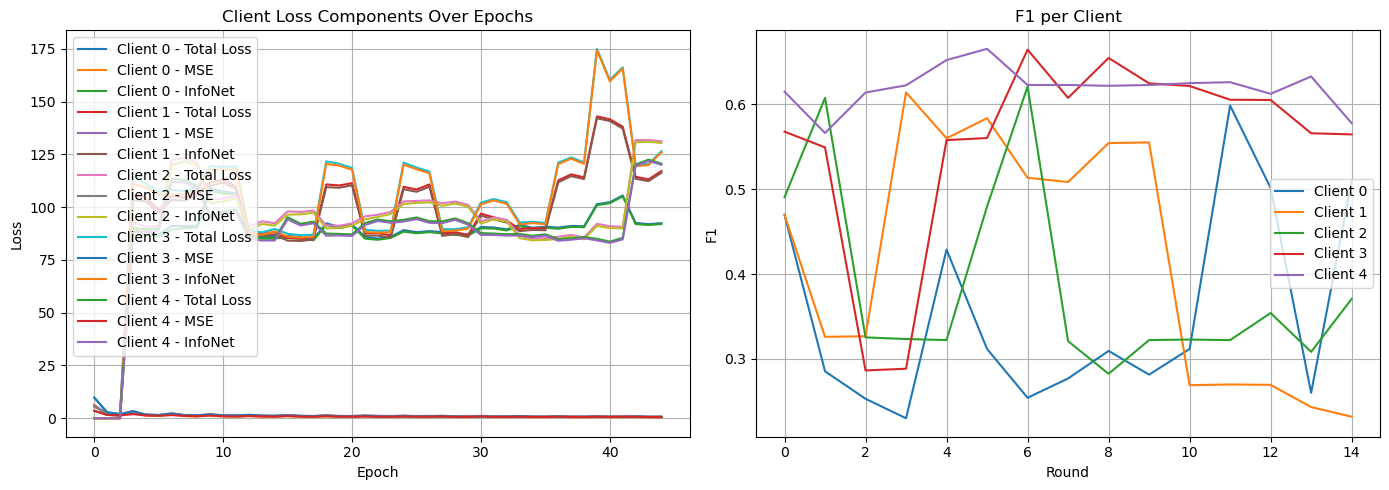

In [4]:
from utils.Toolbox_analysis import plot_all_clients_side_by_side

plot_all_clients_side_by_side_proto(model, priv_train_loaders, metric='f1')

In [5]:
# label_clients = ['District_A', 'District_B', 'District_C', 'District_D', 'District_E']
# label_clients = ['District_A', 'District_B', 'District_C']
label_clients = ['District_A', 'District_B', 'District_C', 'District_D', 'District_E',
                 'District_2A', 'District_2B', 'District_2C']

base_index = results['Baseline']['dl'][0]['X_index']

latent_dfs = {}
for scenario, case in results.items():
    latent_dfs[scenario] = {}
    for epoch, space in enumerate(case['lat']):
        aux_latents = []
        for i, client in enumerate(space):
            baseline_lat = create_latent_df(X_index=base_index,
                                            x_lat=client,
                                            label=scenario + '__' + label_clients[i] + '__' + str(epoch),
                                            is_unix=True)

            aux_latents.append(baseline_lat)

        df_latent = pd.concat(aux_latents)

        df_latent, df_pca_raw, df_umap_raw, df_pca_scaled, df_umap_scaled = process_latent_df(df_latent, umap_neighbors=50, umap_min_dist=0.95)

        latent_dfs[scenario][epoch] = {}
        latent_dfs[scenario][epoch]['latent_space'] = df_latent
        latent_dfs[scenario][epoch]['pca_raw'] = df_pca_raw
        latent_dfs[scenario][epoch]['pca_scl'] = df_pca_scaled
        latent_dfs[scenario][epoch]['umap_raw'] = df_umap_raw
        latent_dfs[scenario][epoch]['umap_scl'] = df_umap_scaled

In [6]:
import pickle

agg_int = int((args.interval_agg) / (60**2))
with open(f'results/exp_latente_results_graeme_{agg_int}_{args.window_size}_proto_month.pkl', 'wb') as file:
    pickle.dump(results, file)

with open(f'results/exp_latente_df_graeme_{agg_int}_{args.window_size}_proto_month.pkl', 'wb') as file:
    pickle.dump(latent_dfs, file)

In [ ]:
PARO

In [13]:
X_index = results['Baseline']['dl'][0]['X_index']
timestamps = pd.to_datetime(X_index, unit='s')
hour = timestamps.hour
label = hour.where(hour < 12, hour - 12).to_numpy()
label = label / (args.interval_agg / (60**2))
label

array([0., 1., 2., ..., 4., 5., 0.])

In [10]:
timestamps

DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 02:00:00',
               '1970-01-01 04:00:00', '1970-01-01 06:00:00',
               '1970-01-01 08:00:00', '1970-01-01 10:00:00',
               '1970-01-01 12:00:00', '1970-01-01 14:00:00',
               '1970-01-01 16:00:00', '1970-01-01 18:00:00',
               ...
               '1970-07-22 06:00:00', '1970-07-22 08:00:00',
               '1970-07-22 10:00:00', '1970-07-22 12:00:00',
               '1970-07-22 14:00:00', '1970-07-22 16:00:00',
               '1970-07-22 18:00:00', '1970-07-22 20:00:00',
               '1970-07-22 22:00:00', '1970-07-23 00:00:00'],
              dtype='datetime64[ns]', length=2437, freq=None)

In [ ]:
# aux_latent[EPOCH][CLIENT]
aux_latent[0][0].shape

In [ ]:
def create_latent_df(X_index, x_lat, label='Teste', is_unix=False):
    """
    Create a DataFrame with timestamps, latent vector components, and anomaly labels.

    Parameters:
    - X_index: array of shape (n_samples,), can be UNIX timestamps or datetime
    - x_lat: array of shape (n_samples, n_latent_dims)
    - anomaly_df: DataFrame with 'start' and 'end' columns for anomaly intervals
    - is_unix: bool, if True converts X_index from UNIX timestamp to datetime

    Returns:
    - DataFrame with 'timestamp', 'label', and x_0 to x_n columns
    """
    # Step 1: Convert timestamps if needed
    if is_unix:
        timestamps = pd.to_datetime(X_index, unit='s')
    else:
        timestamps = pd.to_datetime(X_index)  # ensures consistent datetime dtype

    # Step 2: Create column names for latent dimensions
    latent_dim_names = [f'x_{i}' for i in range(x_lat.shape[1])]

    # Step 3: Create DataFrame
    df = pd.DataFrame(x_lat, columns=latent_dim_names)
    df['timestamp'] = timestamps
    df['label'] = label

    # Step 5: Reorder columns
    df = df[['timestamp', 'label'] + latent_dim_names]

    return df

In [ ]:
results['Drift_PIPELINE_LOW'] = {}

results['Drift_PIPELINE_LOW']['Baseline'] = (priv_train_loaders, aux_latent[-1], model)

In [ ]:
# >> PARA CADA SEGMENTO
## >>>> UTILIZAR MODELO DO SEGMENTO INICIAL PARA LEVAR TODOS NO MESMO ESPAÇO
import pandas as pd

nets_list_base = model.nets_list

latent_dfs = []
for j, (segment, case) in enumerate(results.items()):
    # label_clients = ['District_A', 'District_B', 'District_C', 'District_D', 'District_E']
    # label_clients = ['District_A', 'District_B', 'District_C']
    label_clients = ['District_A', 'District_B', 'District_C', 'District_D', 'District_E',
                     'District_2A', 'District_2B', 'District_2C']
    aux_latents = []

    for i, client in enumerate(label_clients):
        _, _, _, x_lat = nets_list_base[0].predict(case['Baseline'][0][i]['X'])

        baseline_lat = create_latent_df(X_index=case['Baseline'][0][i]['X_index'],
                                        x_lat=x_lat,
                                        label=segment + '_' + client,
                                        is_unix=True)

        aux_latents.append(baseline_lat)

    df_latent = pd.concat(aux_latents)
    df_latent['timestamp'] += pd.Timedelta(days=30 * j)
    latent_dfs.append(df_latent)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
import umap.umap_ as umap


def reduce_dims(X, method = None, n_components=2, umap_neighbors=15, umap_min_dist=0.1):
    """
    Applies PCA and UMAP to the input data.

    Parameters:
    - X: array-like of shape (n_samples, n_features)
    - n_components: int, number of dimensions for the projection
    - umap_neighbors: int, UMAP neighbors
    - umap_min_dist: float, UMAP min_dist

    Returns:
    - X_pca: PCA-reduced data
    - X_umap: UMAP-reduced data
    """

    pca = PCA(n_components=n_components)

    X_pca = pca.fit_transform(X)
    if method == 'PCA':
        return X_pca, None

    reducer = umap.UMAP(n_components=n_components, n_neighbors=umap_neighbors, min_dist=umap_min_dist)
    X_umap = reducer.fit_transform(X)
    if method == 'UMAP':
        return None, X_umap

    return X_pca, X_umap


def plot_reduced_method(X_pca, X_umap, labels=None, method='PCA', ax=None, title=None):
    """
    Plots reduced data based on the selected method (PCA or UMAP).
    Accepts external axis (ax) for subplot usage.
    """
    if method not in ['PCA', 'UMAP']:
        raise ValueError("Invalid method! Use 'PCA' or 'UMAP'.")

    internal_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
        internal_fig = True
    else:
        fig = ax.figure

    # Setup
    if labels is not None:
        labels = np.array(labels)
        unique_labels = np.unique(labels)
        colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
        label_color_map = {label: color for label, color in zip(unique_labels, colors)}

        for label in unique_labels:
            idx = labels == label
            if method == 'PCA':
                ax.scatter(X_pca[idx, 0], X_pca[idx, 1], c=[label_color_map[label]], label=f"{label}", s=10)
            else:
                ax.scatter(X_umap[idx, 0], X_umap[idx, 1], c=[label_color_map[label]], label=f"{label}", s=10)

        legend_elements = [Patch(facecolor=label_color_map[label], label=f'{label}') for label in unique_labels]
        ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1))
    else:
        proj = X_pca if method == 'PCA' else X_umap
        ax.scatter(proj[:, 0], proj[:, 1], s=10)

    ax.set_title(title if title else f"{method} Projection")
    ax.axis("off")

    if internal_fig:
        plt.tight_layout()
        plt.show()

In [ ]:
df_latent = pd.concat(latent_dfs)
df_latent['week'] = df_latent['timestamp'].dt.to_period('W').astype(str)
df_latent['hour'] = df_latent['timestamp'].dt.hour

# Dimensionality reduction
X_pca, X_umap = reduce_dims(
    X=df_latent.iloc[:, 2:-2],  # adjust index if needed
    method='UMAP',
    n_components=2,
    umap_neighbors=50,
    umap_min_dist=.75
)

In [ ]:
import ipywidgets as widgets
from IPython.display import clear_output

hour_options = sorted(df_latent['hour'].unique())

hour_selector = widgets.SelectMultiple(
    options=hour_options,
    value=[hour_options[0]],
    description='Hour(s):',
    # layout=widgets.Layout(width='50%')
)

# Create the dropdown and slider widgets
method_dropdown = widgets.Dropdown(
    options=['UMAP', 'PCA'],
    value='UMAP',
    description='Method:'
)

# Get available weeks from your timestamp column
available_weeks = sorted(df_latent['week'].unique())

week_slider = widgets.SelectionSlider(
    options=available_weeks,
    value=available_weeks[0],
    description='Week:',
    continuous_update=False,
    # layout=widgets.Layout(width='80%')
)


def update_plot(method, week, hours):
    clear_output(wait=True)

    # Filter by week and selected hours
    df_filtered = df_latent.reset_index(drop=True)
    df_filtered = df_filtered[(df_filtered['week'] == week) & (df_filtered['hour'].isin(hours))]

    print(df_filtered.shape)
    if df_filtered.empty:
        print("No data for selected filters.")
        return

    fig, ax = plt.subplots(figsize=(4, 3))  # Change width and height as desired

    # Plot
    plot_reduced_method(
        X_umap[df_filtered.index, :], X_umap[df_filtered.index, :],
        method=method,
        labels=df_filtered['label'],
        ax=ax
    )


widgets.interact(update_plot, method=method_dropdown, week=week_slider, hours=hour_selector)

In [ ]:
import pandas as pd

# Suppose X_umap and X_pca are available
# Add coordinates to df_latent
df_latent['umap_x'] = X_umap[:, 0]
df_latent['umap_y'] = X_umap[:, 1]


import altair as alt

# Create a selection for hour and week
hour_selection = alt.selection_multi(fields=['hour'], name="Select")
week_selection = alt.selection_single(fields=['week'], name="Week", bind='legend')

# Dropdown for method (UMAP/PCA)
method_dropdown = alt.selection_point(options=['UMAP'], name='Method: ')
method_selection = alt.selection_point(fields=['method'], bind=method_dropdown, name='Method')

# Prepare long-form data
df_umap = df_latent[['umap_x', 'umap_y', 'label', 'hour', 'week']].copy()
df_umap['method'] = 'UMAP'
df_umap = df_umap.rename(columns={'umap_x': 'x', 'umap_y': 'y'})


df_long = df_umap



In [ ]:
chart = alt.Chart(df_long).mark_circle(size=60).encode(
    x='x',
    y='y',
    color='label:N',
    tooltip=['label', 'hour', 'week'],
    opacity=alt.condition(hour_selection, alt.value(1), alt.value(0.05))
).add_selection(
    hour_selection,
    week_selection,
    method_selection
).transform_filter(
    hour_selection
).transform_filter(
    week_selection
).transform_filter(
    method_selection
).properties(
    width=500,
    height=400,
    title='Latent Space Visualization'
)

chart
